In [18]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel

np.random.seed(666) #just for reaptable results

def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

In [19]:
df1 = pd.read_excel('./proteins_processed.xlsx', index_col = 0)
df2 = pd.read_excel('./Metabolites_processed.xlsx', index_col = 0)
df2 = df2.loc[df1.index]

df = df1.join(df2)
dfx = df[df.columns[2:]]


In [20]:
dfx.shape

(41, 1486)

In [21]:
df.to_excel('./proteins_metabolites.xlsx')

In [22]:
dfx.shape, df2.shape, df1.shape

((41, 1486), (41, 847), (41, 641))

In [23]:
dfy = df[['Severe']]*1.

In [24]:
mp = AggMap(dfx, metric = 'correlation')
mp.fit(cluster_channels = 5, verbose = 0,)

2020-12-08 15:16:05,306 - INFO - [bidd-aggmap] - Calculating distance ...
2020-12-08 15:16:05,443 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 1486/1486 [00:01<00:00, 796.23it/s]


2020-12-08 15:16:44,385 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-12-08 15:16:47,522 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-12-08 15:16:50,489 - INFO - [bidd-aggmap] - Finished


In [25]:
mp.fmap_shape

(39, 39)

In [26]:
tr = df[df['Train_Test'] == 'Train'].index
ts = df[df['Train_Test'] == 'Test'].index

In [27]:
y = pd.get_dummies(dfy['Severe'])[[1,0]]

Y = y.loc[tr].values
X = dfx.loc[tr].values

Y_test = y.loc[ts].values
X_test = dfx.loc[ts].values

In [28]:
trainX = mp.batch_transform(X, scale_method = 'standard')
testX = mp.batch_transform(X_test, scale_method = 'standard')

print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

# fit the model
clf = AggModel.MultiClassEstimator(epochs = 50,  batch_size = 1, verbose = 0,)
clf.fit(trainX, Y)

# save the model for explaination
clf._model.save( './model.h5')

# make prediction
y_true = Y_test[:,0]
y_pred = clf.predict(testX)[:,0]
y_score = clf.predict_proba(testX)[:,0]

res = {'index':ts, 'y_true':y_true, 'y_score':y_score}
dfres = pd.DataFrame(res)


100%|##########| 10/10 [00:00<00:00, 168.05it/s]



 input train and test X shape is (31, 39, 39, 5), (10, 39, 39, 5) 
MultiClassEstimator(batch_size=1, epochs=50, gpuid='0')


In [29]:
dfres

,index,y_true,y_score
0,XG20,0,0.022462
1,XG21,0,0.401955
2,XG22,0,0.663963
3,XG44,1,1.000000
4,XG43,1,0.976507
5,XG23,0,0.001900
6,XG24,0,0.274577
7,XG25,0,0.793631
8,XG46,1,0.997928
9,XG45,1,0.999459


In [30]:
dfres = pd.DataFrame(res)
dfres

y_true = dfres.y_true.values
y_pred = dfres.y_score.values.round()
y_score = dfres.y_score.values


tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

acc = (tp + tn) / sum([tn, fp, fn, tp])

sensitivity = tp / sum([tp, fn])
specificity = tn / sum([tn, fp])

prc_auc = prc_auc_score(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

precision = tp / sum([tp, fp])
recall =  tp / sum([tp, fn]) #equals to sensitivity


res = {
    
       'accuracy':acc, 

       'prc_auc':prc_auc, 
       'roc_auc':roc_auc,

       'sensitivity': sensitivity, 
       'specificity': specificity,

       'precision':precision,
       'recall':recall,

       'F1': 2*precision*sensitivity/(precision+sensitivity)
      }

res

{'accuracy': 0.8,
 'prc_auc': 1.0,
 'roc_auc': 1.0,
 'sensitivity': 1.0,
 'specificity': 0.6666666666666666,
 'precision': 0.6666666666666666,
 'recall': 1.0,
 'F1': 0.8}

In [31]:
from molmap import loadmap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import KFold

import warnings, os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm


warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]="7"


def CalcFeatImp(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False):
    '''
    Forward prop. Feature importance
    '''
    
    if task_type == 'classification':
        f = log_loss
    else:
        f = mean_squared_error
        
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    grid = mp.plot_grid()
    Y_true = dfY.values
    df_grid = mp.df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    Y_prob = model.predict(arrX)
    N, W, H, C = arrX.shape
    
    if (sigmoidy) & (task_type == 'classification'):
        Y_prob = sigmoid(Y_prob)

    final_res = {}
    for k, col in enumerate(dfY.columns):
        print('calculating feature importance for %s ...' % col)
        
        results = []
        loss = f(Y_true[:, k].tolist(), Y_prob[:, k].tolist())
        for i in tqdm(range(len(df_grid)), ascii= True):
            ts = df_grid.iloc[i]
            y = ts.y
            x = ts.x
            X1 = copy(arrX)
            X1[:, y, x,:] = np.full(X1[:, y, x,:].shape, fill_value = arrX.min())
            #Y1 = model.predict(X1)
            Y_pred_prob = model.predict(X1)
            if (sigmoidy) & (task_type == 'classification'):
                Y_pred_prob = sigmoid(Y_pred_prob)
            mut_loss = f(Y_true[:, k].tolist(), Y_pred_prob[:, k].tolist()) 
            res =  mut_loss - loss # if res > 0, important, othervise, not important
            results.append(res)
            
        final_res.update({col:results})
    df = pd.DataFrame(final_res)
    df.columns = df.columns + '_importance'
    df = df_grid.join(df)
    return df

In [32]:
arrX = trainX
dfY = pd.DataFrame(Y, columns = ['severe', 'non-severe'])
model = clf._model
df_imp = CalcFeatImp(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False)

  0%|          | 3/1521 [00:00<01:02, 24.15it/s]

2020-12-08 15:17:10,202 - INFO - [bidd-aggmap] - generate file: ./feature points_1486_correlation_umap_mp
2020-12-08 15:17:10,233 - INFO - [bidd-aggmap] - save html file to ./feature points_1486_correlation_umap_mp
calculating feature importance for severe ...


  0%|          | 3/1521 [00:00<01:02, 24.15it/s]

calculating feature importance for non-severe ...


100%|##########| 1521/1521 [01:07<00:00, 22.49it/s]


In [33]:
df_imp.sort_values('severe_importance', ascending=False).head(30)

,x,y,v,Subtypes,colors,severe_importance,non-severe_importance
266,32,6,1-palmitoyl-2-dihomo-linolenoyl-GPC (16:0/20:3...,cluster_03,#00fff6,0.009723,0.009723
321,9,8,A0A075B6S6,cluster_04,#0010ff,0.006777,0.006777
322,10,8,sphinganine,cluster_03,#00fff6,0.006733,0.006733
264,30,6,1-palmitoyl-2-linoleoyl-GPC (16:0/18:2),cluster_03,#00fff6,0.006623,0.006623
397,7,10,P24592,cluster_05,#ee00ff,0.006530,0.006530
669,6,17,P36222,cluster_05,#ee00ff,0.006472,0.006472
474,6,12,Q86YZ3,cluster_04,#0010ff,0.006470,0.006470
711,9,18,Q9UM47,cluster_03,#00fff6,0.006432,0.006432
710,8,18,Q8WWZ8,cluster_03,#00fff6,0.006404,0.006404
555,9,14,Q6YHK3,cluster_05,#ee00ff,0.006380,0.006381


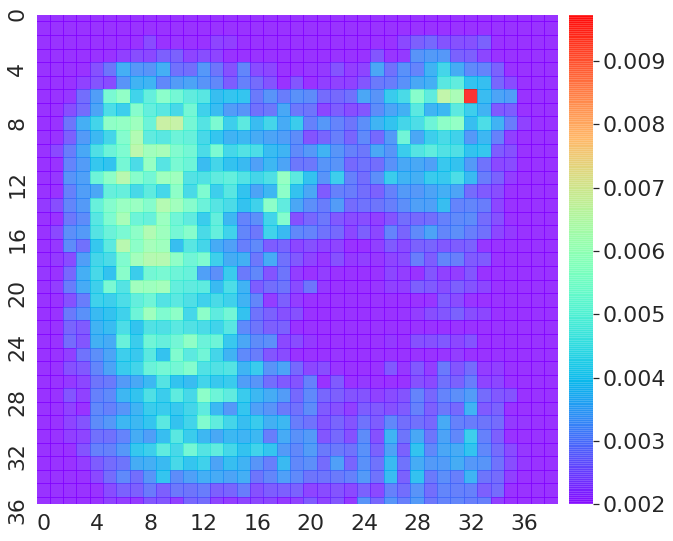

In [34]:
sns.set(style='white',  font='sans-serif', font_scale=2)
fig, ax  = plt.subplots(1, 1, figsize=(10, 9))

IMPM = df_imp['severe_importance'].values.reshape(*mp.fmap_shape)
sns.heatmap(IMPM,  
            cmap = 'rainbow', alpha = 0.8, xticklabels=4, ax =ax,
            yticklabels=4,  vmin = 0.002,
            cbar_kws = {'fraction':0.046, 'pad':0.02})